# [LAB08] 지도학습 > 예측 > 앙상블 > 03-BaggingRandomForest

## #01. 랜덤포레스트 개요

의사결정나무(Decision Tree) 여러 개를 결합한 배깅(Bagging) 기반 앙상블 회귀 모델

개별 나무의 예측값을 평균하여 최종 예측값을 생성함

단일 트리의 과적합 문제를 완화하는 것이 핵심 목적임

## #02. 준비작업

### [1] 패키지 참조

In [1]:
from hossam import *
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import product

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler

# 성능 평가 지표 모듈
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)

# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor

import sys

sys.path.append("/Users/jinwoo/Machine_Learning")

from hs_eval_utils import (
    hs_get_scores,
    hs_learning_cv,
    hs_get_score_cv,
    feature_importance,
)


import shap

### [2] 성능 평가 함수 정의

- `hs_get_scores()`
- `hs_learning_cv()`
- `hs_get_score_cv()`
- `hs_feature_importance(model, x_train, y_train)` : SVM 예제에서 가져오세요.

### [3] 데이터 가져오기 + 인덱스,타입변환

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)

In [2]:
origin = load_data("restaurant_sales_preprocessed")
origin.set_index("date", inplace=True)
origin["holiday"] = origin["holiday"].astype("category")
origin["weekend"] = origin["weekend"].astype("category")
origin.info()

어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   sales           353 non-null    float64 
 1   visitors        353 non-null    int64   
 2   avg_price       353 non-null    int64   
 3   marketing_cost  353 non-null    float64 
 4   delivery_ratio  353 non-null    float64 
 5   rain_mm         353 non-null    float64 
 6   temperature     353 non-null    float64 
 7   holiday         353 non-null    category
 8   weekend         353 non-null    category
dtypes: category(2), float64(5), int64(2)
memory usage: 23.0 KB


### [4] 훈련, 학습 데이터 분리

In [3]:
df = origin
yname = "sales"
x = df.drop(columns=[yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=52
)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((264, 8), (89, 8), (264,), (89,))

## #03. RandomForest 모델 적합

### [1] 주요 하이퍼파라미터

| 파라미터명 | 핵심도 | 실무 조정 전략 요약 | 기본값 | GridSearchCV | 실무 권장값 |
|-----------|--------|-------------------|--------|--------------|-------------|
| n_estimators | ⭐⭐ | 성능 안정화용, 과도한 탐색 불필요 | 100 | [300, 500] | |
| max_depth | ⭐⭐ | 과적합 보조 제어, 제한적 탐색 | None | [None, 10] | |
| min_samples_leaf | ⭐⭐⭐ | 과적합 통제 핵심 파라미터 | 1 | [5, 10] | |
| max_features | ⭐⭐⭐ | 트리 다양성 핵심, 랜덤포레스트 정체성 | 1.0 | ['sqrt', 1.0] | |
| criterion | | 노드 분할 품질 측정 기준 | "squared_error" | | |
| n_jobs | | 병렬 처리 | None | -1 | |
| random_state | | 재현성 확보 | None | 52 | |

In [4]:
%%time
# 스케일링이 필요 없으므로 Pipeline 생략
rf = RandomForestRegressor(
    random_state=52,
    n_jobs=-1
)

param_grid = { 
    "n_estimators": [300, 500],        # ⭐⭐ 성능 안정화
    "max_depth": [None, 10],           # ⭐⭐ 보조 과적합 제어
    "min_samples_leaf": [5, 10],       # ⭐⭐⭐ 과적합 통제 핵심
    "max_features": ["sqrt", 1.0],     # ⭐⭐⭐ 트리 다양성 핵심
}

gs = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

gs.fit(x_train, y_train)
best_model = gs.best_estimator_
best_model

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 227 ms, sys: 109 ms, total: 336 ms
Wall time: 4.14 s


RandomForestRegressor(min_samples_leaf=5, n_estimators=300, n_jobs=-1,
                      random_state=52)

## #04. 성능평가

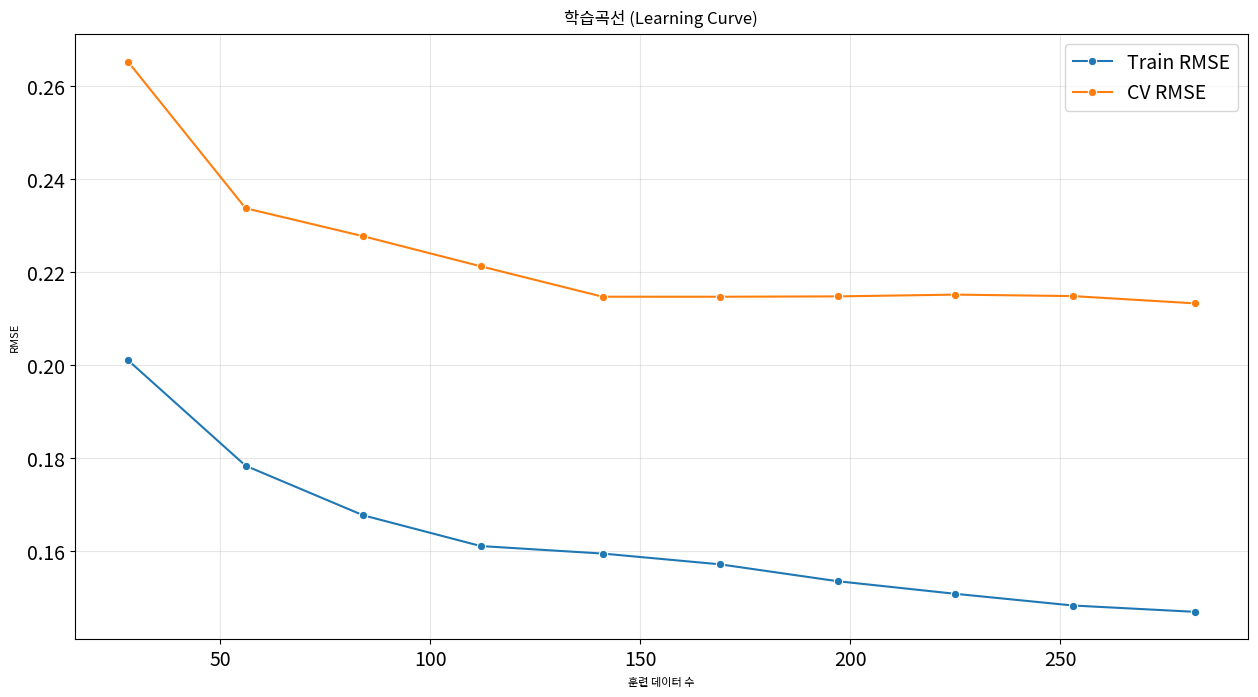

,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
RandomForestRegressor,0.859,0.111,0.021,0.144,0.007,-0.009,0.147,0.213,0.015,0.689,0.072,⚠️ 과대적합 (variance 큼)


In [5]:
hs_get_score_cv(best_model, x_train, y_train, x, y)

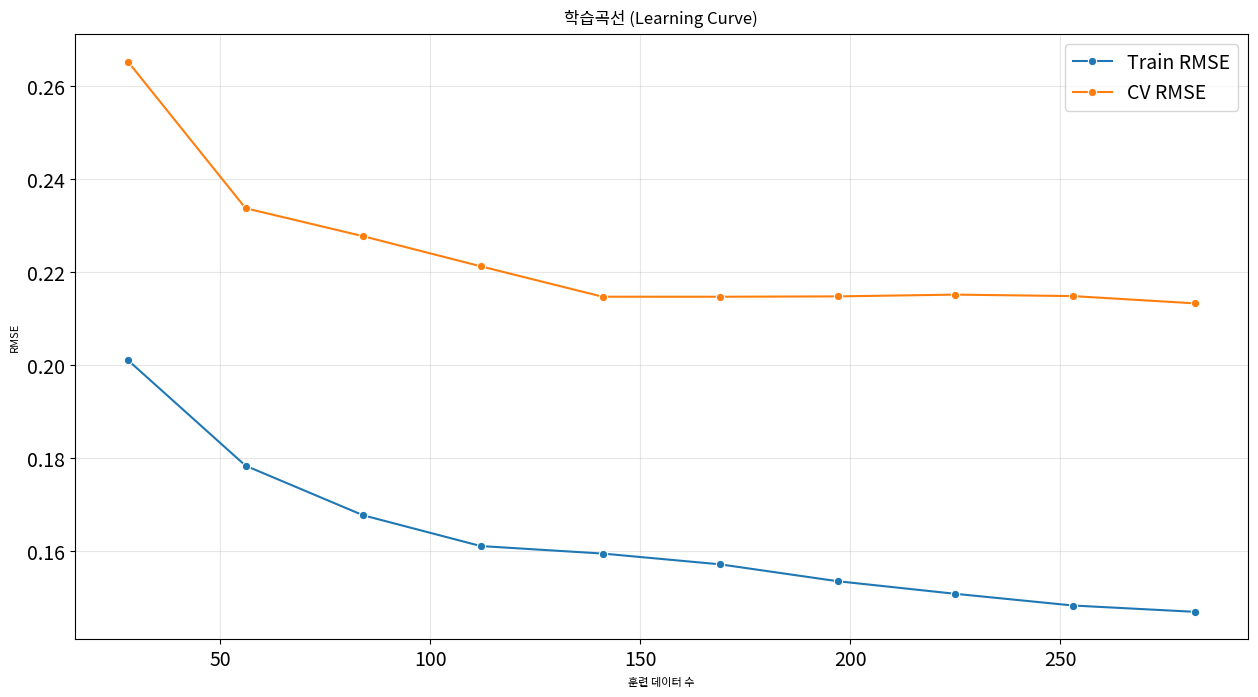

                       Train RMSE  CV RMSE 평균  CV RMSE 표준편차  Train/CV 비율  \
RandomForestRegressor       0.147       0.213         0.015        0.689   

                       CV 변동성 비율                 판정 결과  
RandomForestRegressor      0.072  ⚠️ 과대적합 (variance 큼)  


In [6]:
print(hs_learning_cv(best_model, x, y))

### 성능 평가 결과

| 모델 | 결정계수(R2) | 평균절대오차(MAE) | 평균제곱오차(MSE) | 평균오차(RMSE) | 평균 절대 백분 오차 비율(MAPE) | 평균 비율 오차(MPE) | Train RMSE | CV RMSE 평균 | CV RMSE 표준편차 | Train/CV 비율 | CV 변동성 비율 | 판정 결과 |
|------|--------------|------------------|------------------|----------------|-------------------------------|-------------------|------------|--------------|------------------|---------------|----------------|-----------|
| RandomForestRegressor | 0.859 | 0.111 | 0.021 | 0.144 | 0.007 | -0.009 | 0.147 | 0.213 | 0.015 | 0.689 | 0.072 | 과대적합(variance 큼) |

### 💡 인사이트

**전형적인 랜덤포레스트 과적합 패턴**

모델은 훈련 데이터를 지나치게 잘 설명하고 있으며, 검증 데이터로 일반화될 때 성능이 크게 흔들림

## #05. 결과 해석

### [1] 변수 중요도 판별

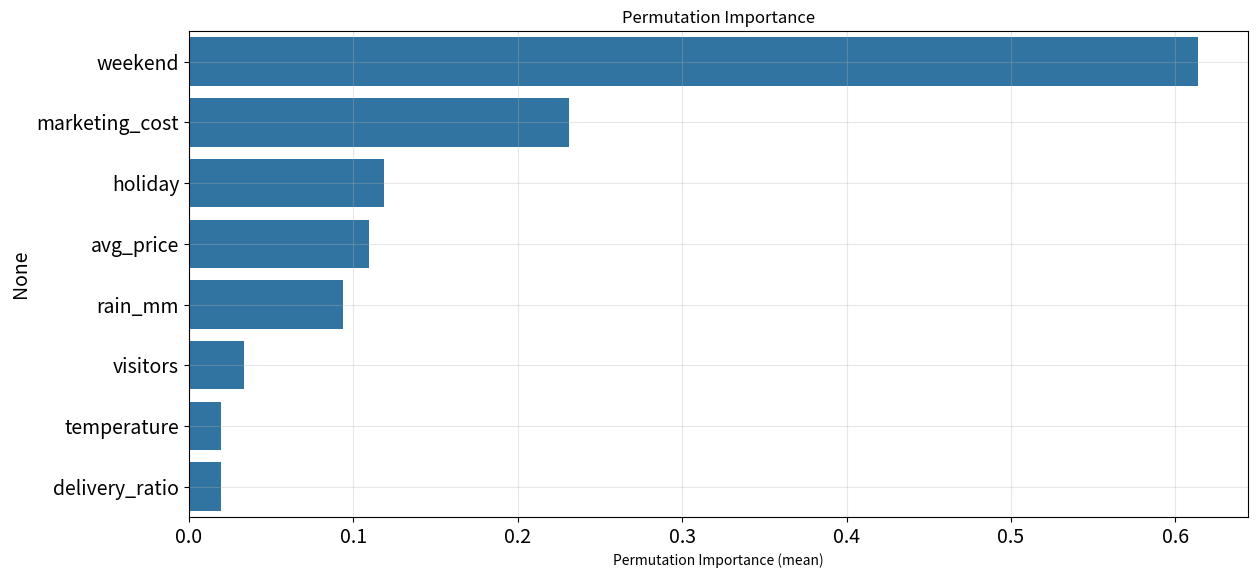

,importance_mean,importance_std,importance_cumsum
weekend,0.613,0.064,0.613
marketing_cost,0.231,0.027,0.844
holiday,0.119,0.016,0.963
avg_price,0.109,0.014,1.073
rain_mm,0.094,0.009,1.166
visitors,0.033,0.004,1.200
temperature,0.020,0.002,1.219
delivery_ratio,0.020,0.002,1.239


In [7]:
feature_importance(best_model, x_train, y_train)

**변수 중요도 결과:**

| 변수명 | importance_mean | importance_std | importance_cumsum |
|--------|-----------------|----------------|-------------------|
| weekend | 0.613 | 0.064 | 0.613 |
| marketing_cost | 0.231 | 0.027 | 0.844 |
| holiday | 0.119 | 0.016 | 0.963 |
| avg_price | 0.109 | 0.014 | 1.073 |
| rain_mm | 0.094 | 0.009 | 1.166 |
| visitors | 0.033 | 0.004 | 1.200 |
| temperature | 0.020 | 0.002 | 1.219 |
| delivery_ratio | 0.020 | 0.002 | 1.239 |

### 💡 변수별 인사이트

| 변수명 | 인사이트 |
|--------|---------|
| weekend | 전체 중요도의 약 61%를 차지하는 핵심 변수로, 모델이 주말/비주말 구분에 매우 강하게 의존하고 있어 설명력은 높지만 과대적합 위험과도 직접 연결됨. |
| marketing_cost | 누적 설명력의 84%를 형성하는 2순위 핵심 변수로, 마케팅 비용이 종속변수에 안정적이고 직접적인 영향을 미치는 주요 조절 변수로 해석됨. |
| holiday | 주말 변수와 함께 캘린더 효과를 구성하며, 독립적 영향은 있으나 weekend와 중복 설명 가능성이 존재함. |
| avg_price | 가격 효과는 존재하지만 주말·마케팅 변수 대비 영향력이 작아, 가격보다 수요 구조 요인이 더 중요함을 시사함. |
| rain_mm | 기상 변수 중 의미 있는 수준의 중요도를 가지며, 매출·방문에 보조적 영향을 주는 환경 요인으로 해석됨. |
| visitors | 직관에 비해 중요도가 낮아, 방문자 수 효과가 주말·휴일 변수에 흡수되었을 가능성이 큼. |
| temperature | 영향력이 매우 낮아 모델 예측에서 주변 변수 수준에 머물며, 제거해도 성능 변화가 크지 않을 가능성이 있음. |
| delivery_ratio | 가장 낮은 중요도 그룹에 속하며, 현재 모델 구조에서는 설명 기여도가 제한적인 변수로 판단됨. |

### [2] SHAP 분석

#### SHAP 분석 일괄 처리 함수 정의

In [8]:
def hs_shap_analysis(
    model, x: DataFrame, plot: bool = True, width: int = 1600, height: int = 800
):
    # 1. SHAP Explainer
    explainer = shap.TreeExplainer(model)

    # 2. SHAP 값 계산: shape = [n_samples, n_features]
    shap_values = explainer.shap_values(x)

    # 3. DataFrame 변환
    shap_df = DataFrame(
        shap_values,
        columns=x.columns,
        index=x.index,
    )

    # 4. 요약 통계
    summary_df = DataFrame(
        {
            "feature": shap_df.columns,
            "mean_abs_shap": shap_df.abs().mean().values,
            "mean_shap": shap_df.mean().values,
            "std_shap": shap_df.std().values,
        }
    )

    # 5. 영향 방향 (보수적 표현)
    summary_df["direction"] = np.where(
        summary_df["mean_shap"] > 0,
        "양(+) 경향",
        np.where(summary_df["mean_shap"] < 0, "음(-) 경향", "혼합/미약"),
    )

    # 6. 변동성 지표
    summary_df["cv"] = summary_df["std_shap"] / (summary_df["mean_abs_shap"] + 1e-9)
    summary_df["variability"] = np.where(
        summary_df["cv"] < 1,
        "stable",  # 변동성 낮음 - 평균 대비 일관적 영향 의미
        "variable",  # 변동성 큼 - 상황 의존적 영향 의미
    )

    # 7. 중요도 기준 정렬
    summary_df = summary_df.sort_values("mean_abs_shap", ascending=False).reset_index(
        drop=True
    )

    # 8. 중요 변수 표시 (누적 80%)
    total_importance = summary_df["mean_abs_shap"].sum()
    summary_df["importance_ratio"] = summary_df["mean_abs_shap"] / total_importance
    summary_df["importance_cumsum"] = summary_df["importance_ratio"].cumsum()
    summary_df["is_important"] = np.where(
        summary_df["importance_cumsum"] <= 0.80,
        "core",  # 누적 80% 내 중요 변수 - 모델 핵심 결정 요인 의미 명확
        "secondary",  # 누적 80% 초과 변수 - 보조적/상황적 영향 요인 의미
    )

    # 9. 시각화
    if plot:
        shap.summary_plot(shap_values, x_train, show=False)
        fig = plt.gcf()
        fig.set_size_inches(width / my_dpi, height / my_dpi)
        plt.title("SHAP Summary Plot", fontsize=10, pad=10)
        plt.xlabel("SHAP value", fontsize=8)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=8)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.close()

    return summary_df, shap_values

#### SHAP 분석 실행

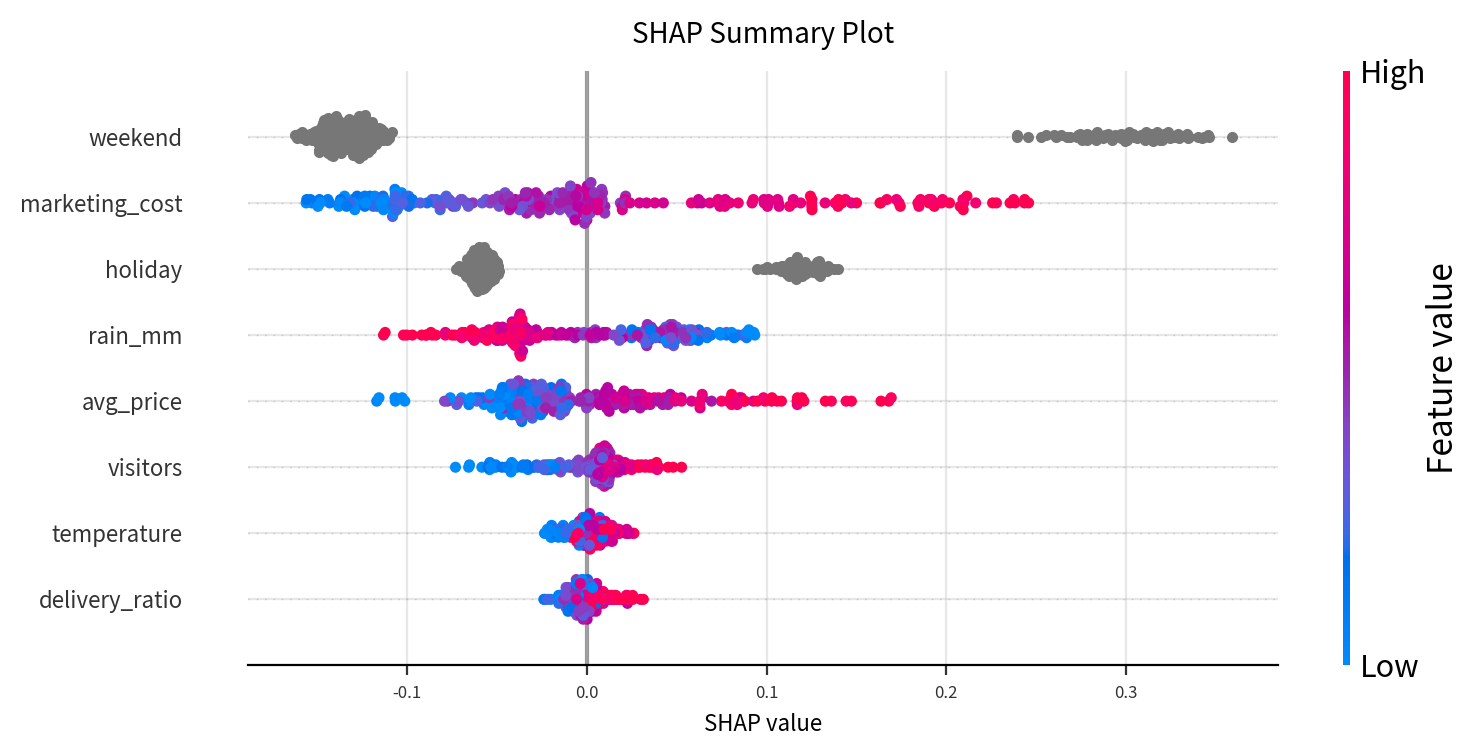

,feature,mean_abs_shap,mean_shap,std_shap,direction,cv,variability,importance_ratio,importance_cumsum,is_important
0,weekend,0.184,-0.004,0.200,음(-) 경향,1.088,variable,0.395,0.395,core
1,marketing_cost,0.081,0.001,0.104,양(+) 경향,1.277,variable,0.174,0.569,core
2,holiday,0.080,0.003,0.085,양(+) 경향,1.065,variable,0.171,0.740,core
3,rain_mm,0.046,-0.001,0.051,음(-) 경향,1.113,variable,0.098,0.838,secondary
4,avg_price,0.043,-0.002,0.054,음(-) 경향,1.252,variable,0.092,0.930,secondary
5,visitors,0.018,0.000,0.023,양(+) 경향,1.301,variable,0.038,0.969,secondary
6,temperature,0.008,0.000,0.010,양(+) 경향,1.291,variable,0.017,0.985,secondary
7,delivery_ratio,0.007,-0.000,0.009,음(-) 경향,1.328,variable,0.015,1.000,secondary


array([[ 0.01366157, -0.04865294, -0.00682275, -0.00855129, -0.04293852,
         0.00485115, -0.06237565, -0.13721416],
       [ 0.00531296,  0.08734606, -0.10821597, -0.00786912, -0.06816537,
         0.00306888, -0.06253319, -0.14253912],
       [-0.01564906, -0.03203023,  0.08419588,  0.00289335, -0.04069614,
        -0.02025376,  0.10970496,  0.29004481],
       [ 0.03225695,  0.02354357, -0.01133451, -0.00095103,  0.06209149,
        -0.00185498, -0.05164813, -0.1102291 ],
       [-0.03498917, -0.01167578, -0.00861744,  0.00689836, -0.04119851,
         0.00561855, -0.05633   , -0.13034683]])

In [9]:
summary_df, shap_values = hs_shap_analysis(best_model, x_train)
display(summary_df)
display(shap_values[:5])

**SHAP 분석 결과:**

| feature | mean_abs_shap | mean_shap | std_shap | direction | cv | variability | importance_ratio | importance_cumsum | is_important |
|---------|---------------|-----------|----------|-----------|----|-----------|--------------------|-------------------|--------------|
| weekend | 0.184 | -0.004 | 0.200 | 음(-) 경향 | 1.088 | variable | 0.395 | 0.395 | core |
| marketing_cost | 0.081 | 0.001 | 0.104 | 양(+) 경향 | 1.277 | variable | 0.174 | 0.569 | core |
| holiday | 0.080 | 0.003 | 0.085 | 양(+) 경향 | 1.065 | variable | 0.171 | 0.740 | core |
| rain_mm | 0.046 | -0.001 | 0.051 | 음(-) 경향 | 1.113 | variable | 0.098 | 0.838 | secondary |
| avg_price | 0.043 | -0.002 | 0.054 | 음(-) 경향 | 1.252 | variable | 0.092 | 0.930 | secondary |
| visitors | 0.018 | 0.000 | 0.023 | 양(+) 경향 | 1.301 | variable | 0.038 | 0.969 | secondary |
| temperature | 0.008 | 0.000 | 0.010 | 양(+) 경향 | 1.291 | variable | 0.017 | 0.985 | secondary |
| delivery_ratio | 0.007 | -0.000 | 0.009 | 음(-) 경향 | 1.328 | variable | 0.015 | 1.000 | secondary |

**💡 이미 이전 실습 내용과 비슷한 결과이므로 인사이트 설명 생략**

#### SHAP summary_df를 기준으로 dependence_plot 시각화 함수

`hs_shap_dependence_analysis()` 함수를 사용하여:
1. SHAP summary_df를 기준으로 dependence_plot 대상 변수 쌍 자동 선정
2. 모든 쌍에 대해 dependence plot 일괄 시각화

In [10]:
def hs_shap_dependence_analysis(
    summary_df: DataFrame,
    shap_values,
    x_train: DataFrame,
    include_secondary: bool = False,
    width: int = 1600,
    height: int = 800,
):
    # 1. 주 대상 변수 (Core + Variable)
    main_features = summary_df[
        (summary_df["is_important"] == "core")
        & (summary_df["variability"] == "variable")
    ]["feature"].tolist()

    # 2. 상호작용 후보 변수
    interaction_features = summary_df[summary_df["is_important"] == "core"][
        "feature"
    ].tolist()

    if include_secondary and len(interaction_features) < 2:
        interaction_features.extend(
            summary_df[summary_df["is_important"] == "secondary"]["feature"].tolist()
        )

    # 3. 변수 쌍 생성 (자기 자신 제외)
    pairs = []
    for f in main_features:
        for inter in interaction_features:
            # 자기 자신과의 조합은 제외
            if f != inter:
                pairs.append((f, inter))

    # 중요도 순 정렬 (주 변수 기준)
    importance_rank = {}
    for i, row in summary_df.iterrows():
        importance_rank[row["feature"]] = i

    pairs = sorted(pairs, key=lambda x: importance_rank.get(x[0], 999))

    # 4. dependence plot 일괄 생성
    for feature_name, interaction_name in pairs:
        shap.dependence_plot(
            feature_name,
            shap_values,
            x_train,
            interaction_index=interaction_name,
            show=False,
        )

        # SHAP figure 직접 제어
        fig = plt.gcf()
        fig.set_size_inches(width / my_dpi, height / my_dpi)
        plt.title(
            f"SHAP Dependence Plot: {feature_name} × {interaction_name}",
            fontsize=10,
            pad=10,
        )
        plt.xlabel(feature_name, fontsize=10)
        plt.ylabel(f"SHAP value for {feature_name}", fontsize=10)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=8)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.close()

    return pairs

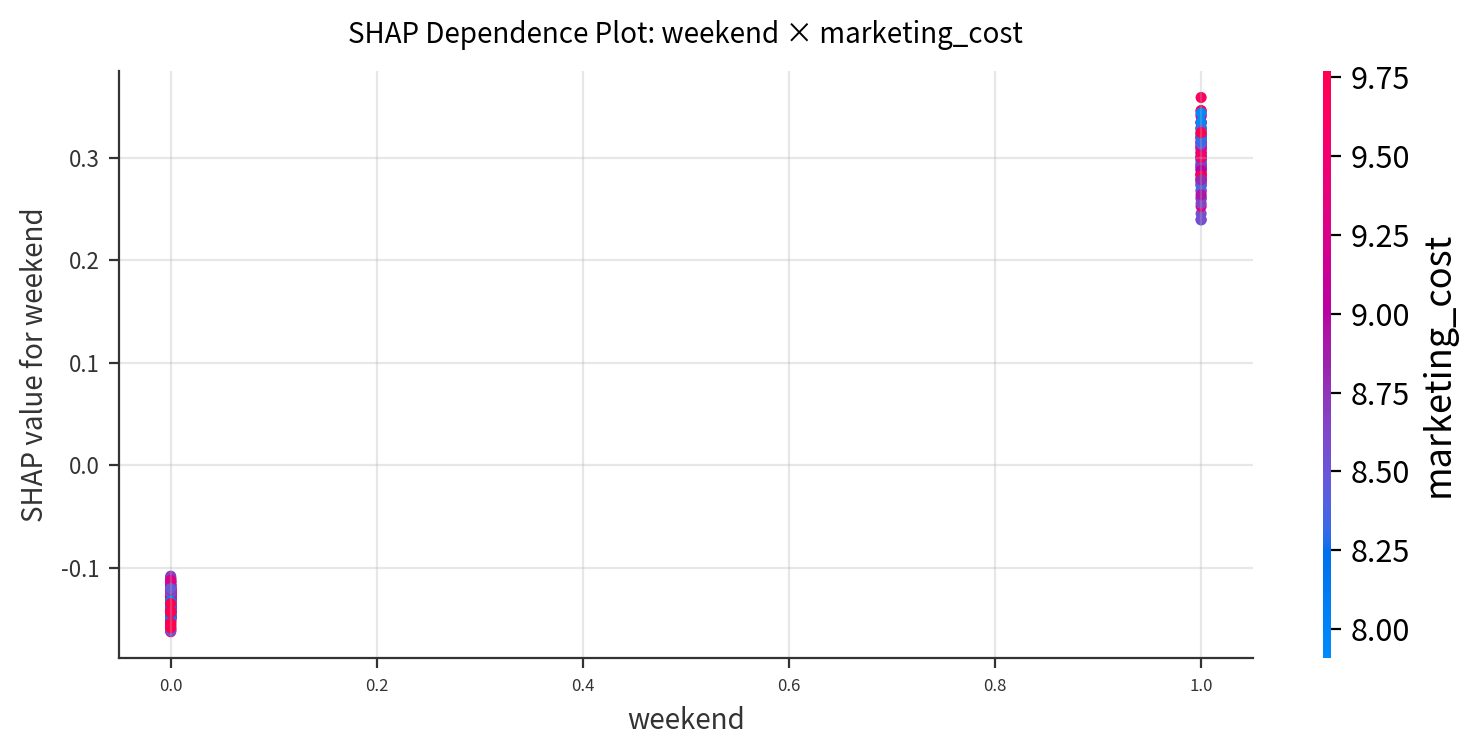

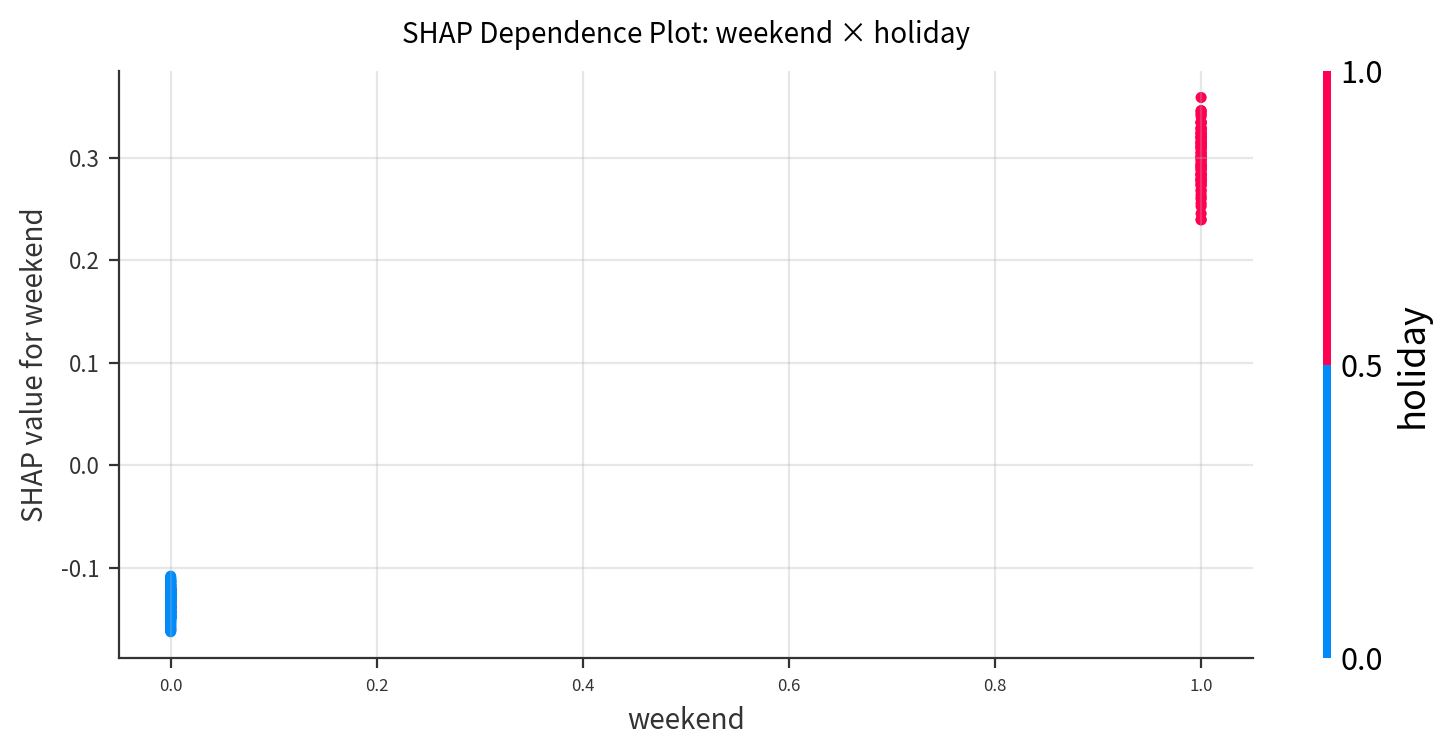

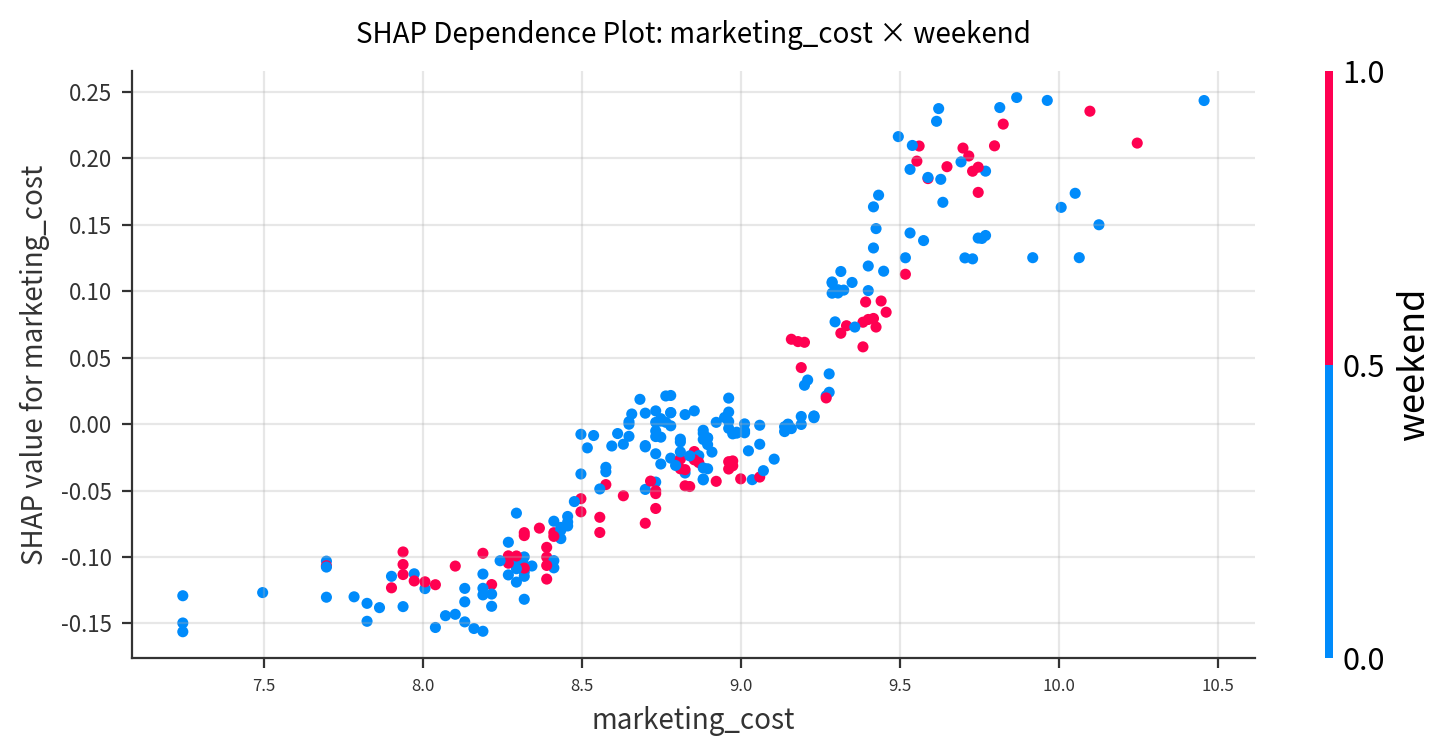

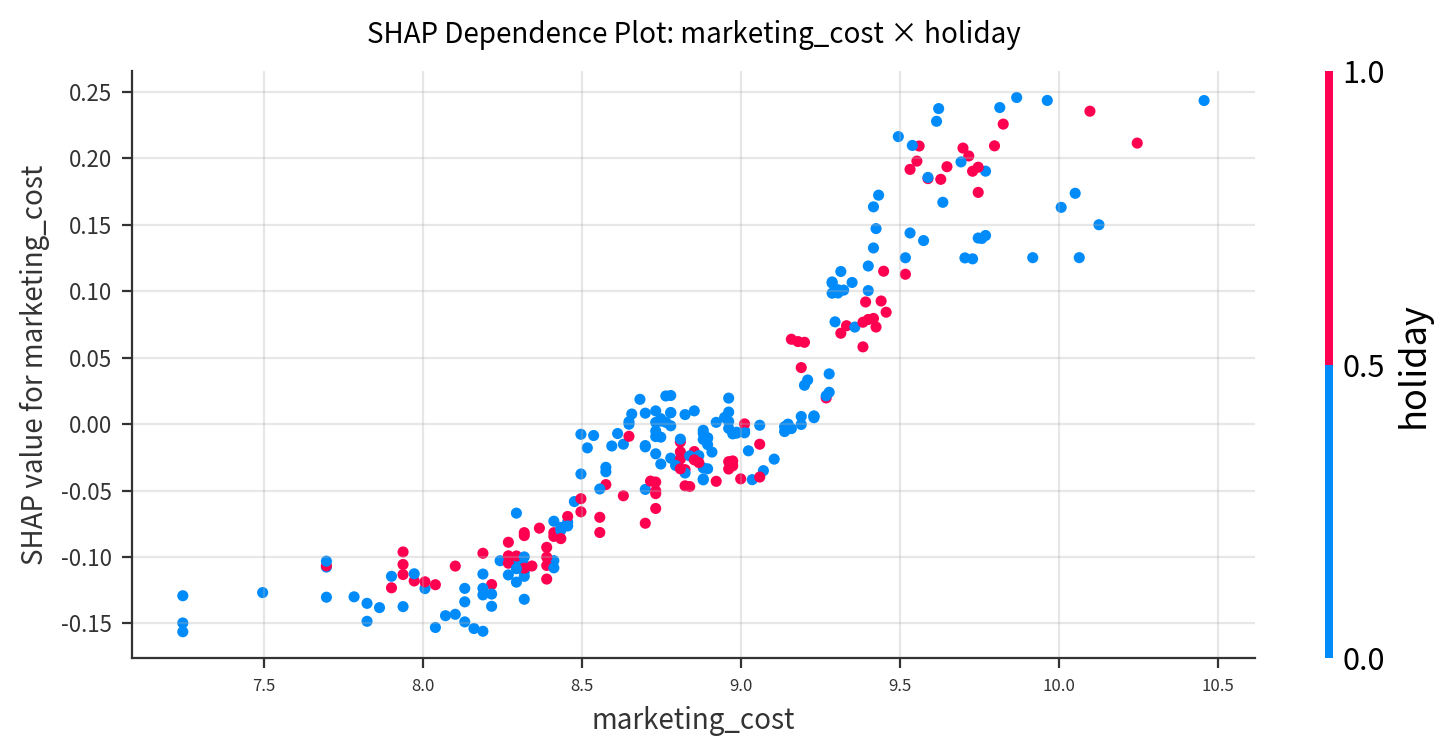

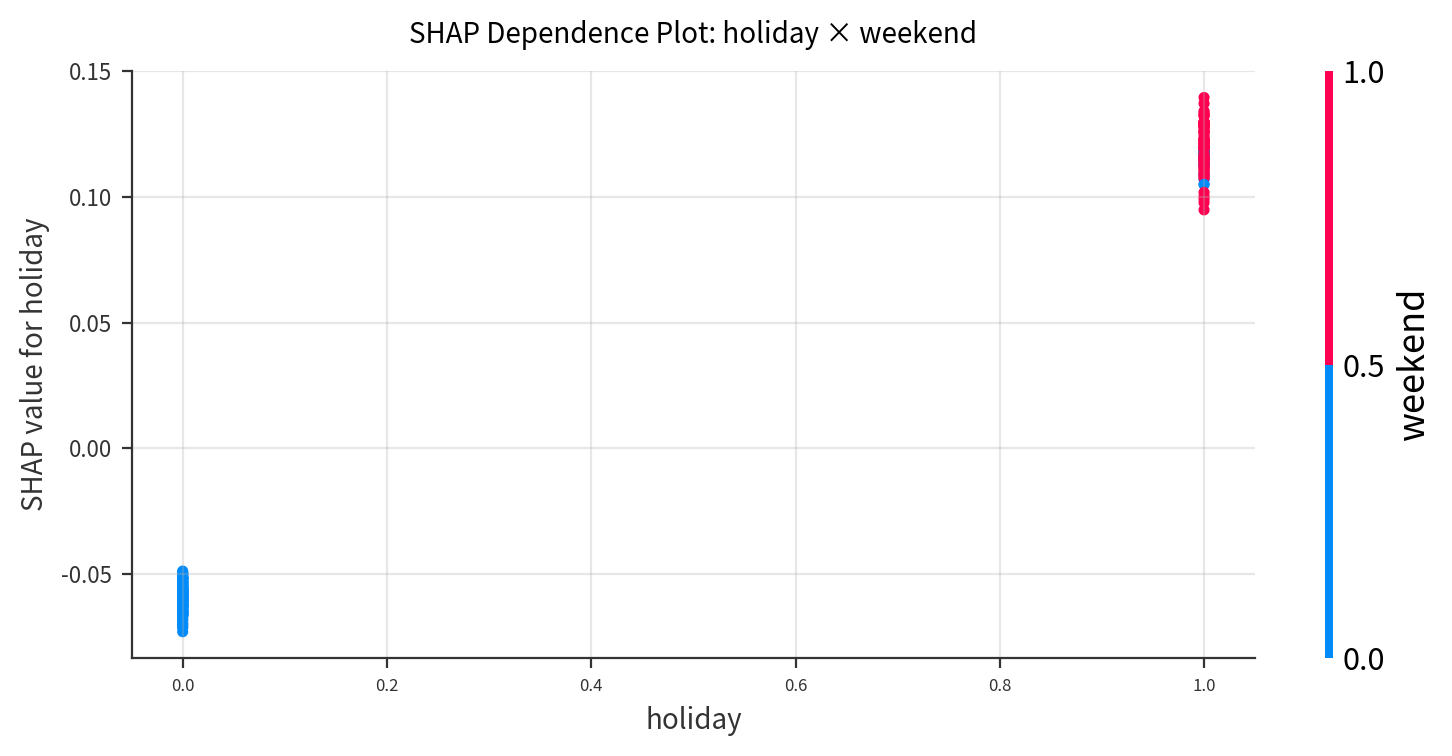

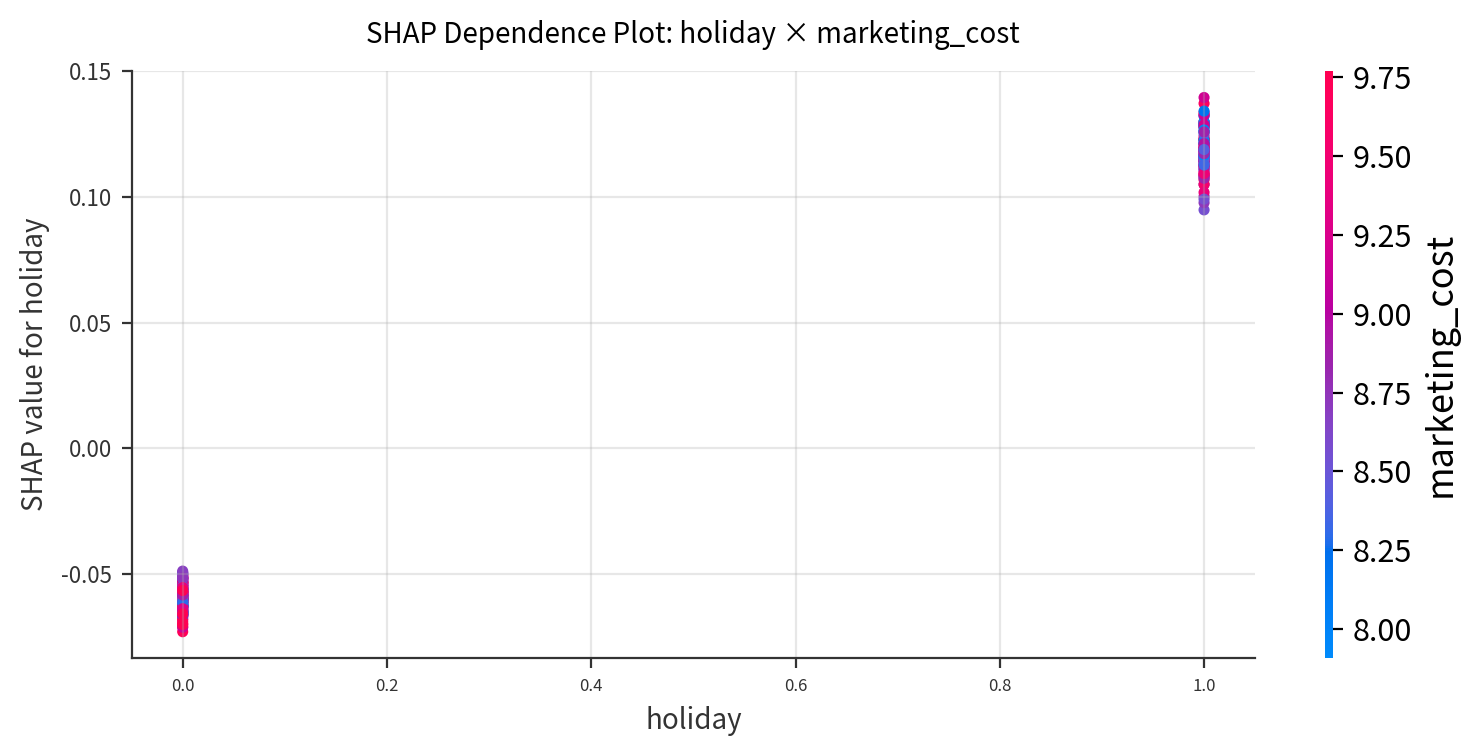

[('weekend', 'marketing_cost'),
 ('weekend', 'holiday'),
 ('marketing_cost', 'weekend'),
 ('marketing_cost', 'holiday'),
 ('holiday', 'weekend'),
 ('holiday', 'marketing_cost')]

In [11]:
hs_shap_dependence_analysis(summary_df, shap_values, x_train, include_secondary=False)